In [1]:
# Import system packages
using Printf
using DelimitedFiles
using Plots
using LaTeXStrings

In [89]:
# Import AGNI
ROOT_DIR = abspath(joinpath(pwd(),"../"))
using AGNI
import AGNI.atmosphere as atmosphere
import AGNI.solver as nl
import AGNI.setpt as setpt
import AGNI.dump as dump
import AGNI.phys as phys
import AGNI.plotting as plotting

# Disable logging from AGNI module
AGNI.setup_logging("",1)

In [3]:
R_earth = 6.371e6  # m
M_earth = 5.972e24 # kg
L_sun   = 3.828e26 # W
AU      = 149597870691.0 # m
G_grav  = 6.67430e-11

6.6743e-11

In [4]:
L_star = 10.0^(-0.268) * L_sun
a_orb  = 0.0104 * AU

1.5558178551864e9

In [5]:
instellation = L_star / (4 * pi * a_orb * a_orb)

6.7896058356847e6

In [6]:
function calc_gravity(_m, _r)
    return G_grav * _m / (_r * _r)
end

calc_gravity (generic function with 1 method)

In [7]:
# Configuration options
mass            = 3*M_earth
radius          = 1.4*R_earth
gravity         = calc_gravity(mass, radius)
println(gravity)
p_surf          = 500.0 # bar

s0_fact         = 0.25
zenith_degrees  = 54.74
albedo_b        = 0.0
nlev_centre     = 30
p_top           = 1e-4      # bar
mole_fractions  = Dict("CO2" => 1.0)
tmp_surf        = 3000.0
thermo          = true

albedo_data   = joinpath(ROOT_DIR,"res/surface_albedos/lunar_marebasalt.dat")
spectral_file = joinpath(ROOT_DIR,"res/spectral_files/nogit_shared/Dayspring/48/Dayspring.sf")
star_file     = joinpath(ROOT_DIR,"res/stellar_spectra/sun.txt")
output_dir    = joinpath(ROOT_DIR,"out/")

15.030571570752072


"/home/n/nichollsh/AGNI/out/"

In [8]:
# Create output directory
rm(output_dir,force=true,recursive=true)
mkdir(output_dir);

In [9]:
# Setup atmosphere
atmos = atmosphere.Atmos_t()
atmosphere.setup!(atmos, ROOT_DIR, output_dir,
                        spectral_file,
                        instellation, s0_fact, albedo_b, zenith_degrees,
                        tmp_surf,
                        gravity, radius,
                        nlev_centre, p_surf, p_top,
                        mole_fractions, "",

                        flux_int = 0.0,
                        flag_gcontinuum=true,
                        flag_rayleigh=true,
                        thermo_functions=thermo,
                        surface_material=albedo_data,
                        overlap_method="ee"
                    )
atmosphere.allocate!(atmos, star_file)

[ INFO  ] Setting-up a new atmosphere struct 
[ INFO  ] Found FastChem executable 
[ INFO  ] Inserting stellar spectrum and Rayleigh coefficients 
[ INFO  ] Allocating atmosphere with composition: 
[ INFO  ]       1 CO2     1.00e+00  


true

In [10]:
# setpt.isothermal!(atmos, 2000.0)

In [11]:
# solver_success = nl.solve_energy!(atmos,
#                                     sol_type=1,
#                                     sens_heat=true,
#                                     latent=false,
#                                     method=1,
#                                     dx_max=400.0,
#                                     ls_method=1,
#                                     save_frames=false, modplot=1,
#                                     conv_atol=1.0,
#                                     modprint=1
#                                     )
# println("Solver success? $solver_success")
# atm_base = deepcopy(atmos);

In [12]:
# atmos = deepcopy(atm_base)
setpt.isothermal!(atmos, 1500.0)

In [13]:
nsamps::Int64 = 4

inp_ps = 10.0 .^ collect(range(start=1.0, stop=4.0, length=nsamps)) # range of surface pressures [log bar]
inp_rp = collect(range(start=1.0, stop=1.5, length=nsamps)) # range of surface radii [R_earth]

# combinations
inp_ps_arr = Float64[]
inp_rp_arr = Float64[]
for i in 1:nsamps
    for j in 1:nsamps
        push!(inp_ps_arr, inp_ps[i])
        push!(inp_rp_arr, inp_rp[j])
    end
end
ntotal = Int(length(inp_ps_arr))

16

In [14]:
atm_arr = atmosphere.Atmos_t[]

@printf("Running model for %d points... \n", ntotal)

for i in 1:ntotal
    @printf("Point %d/%d \n",i,ntotal)
    @printf("   R_surf = %g R_e \n",inp_rp_arr[i])
    @printf("   P_surf = %g bar \n",inp_ps_arr[i])

    atmos.rp = inp_rp_arr[i] * R_earth
    atmos.grav_surf = calc_gravity(mass, atmos.rp)

    atmos.p_boa = inp_ps_arr[i] * 1e5 # convert to Pa
    atmosphere.generate_pgrid!(atmos)

    # Run model
    solver_success = nl.solve_energy!(atmos,
                                    sol_type=3,
                                    method=1,
                                    dx_max=500.0,
                                    ls_method=1,
                                    save_frames=false, modplot=1,
                                    modprint=1, perturb_all=false,
                                    conv_atol=1.0e-2
                                    )

    # Observables
    atmosphere.calc_observed_rho!(atmos)

    # Store result
    push!(atm_arr, deepcopy(atmos))
    @printf("--------------------------------- \n")
end
println("Done!")

Running model for 16 points... 
Point 1/16 
   R_surf = 1 R_e 
   P_surf = 10 bar 
[ INFO  ]     sol_type = 3 
[ INFO  ]     flux_int = 0.00 W m-2 
[ INFO  ]     step  resid_med    cost     flux_OLR    max(x)    max(|dx|)   flags 
[ INFO  ]        1  +3.59e+02  3.287e+05  3.635e+05  2.001e+03  5.000e+02  C2-Nr-Ls 
[ INFO  ]        2  +3.98e+02  4.210e+04  6.654e+05  2.501e+03  5.000e+02  C2-Nr 
[ INFO  ]        3  +1.01e+02  1.597e+04  6.980e+05  2.541e+03  1.978e+02  C2-Nr 
[ INFO  ]        4  +4.90e+00  1.295e+03  6.911e+05  2.538e+03  8.727e+01  C2-Nr 
[ INFO  ]        5  +4.46e-02  4.498e+01  6.903e+05  2.538e+03  1.842e+01  C2-Nr 
[ INFO  ]        6  +1.57e-05  5.242e-02  6.903e+05  2.538e+03  6.587e-01  C2-Nr 
[ INFO  ]        7  +2.09e-07  6.948e-04  6.903e+05  2.538e+03  6.913e-04  C2-Nr 
[ INFO  ]     success in 7 steps 
[ INFO  ]     outgoing LW flux   = +6.90e+05 W m-2      
[ INFO  ]     total flux at TOA  = +4.56e-04 W m-2      
[ INFO  ]     total flux at BOA  = -1.69e-04

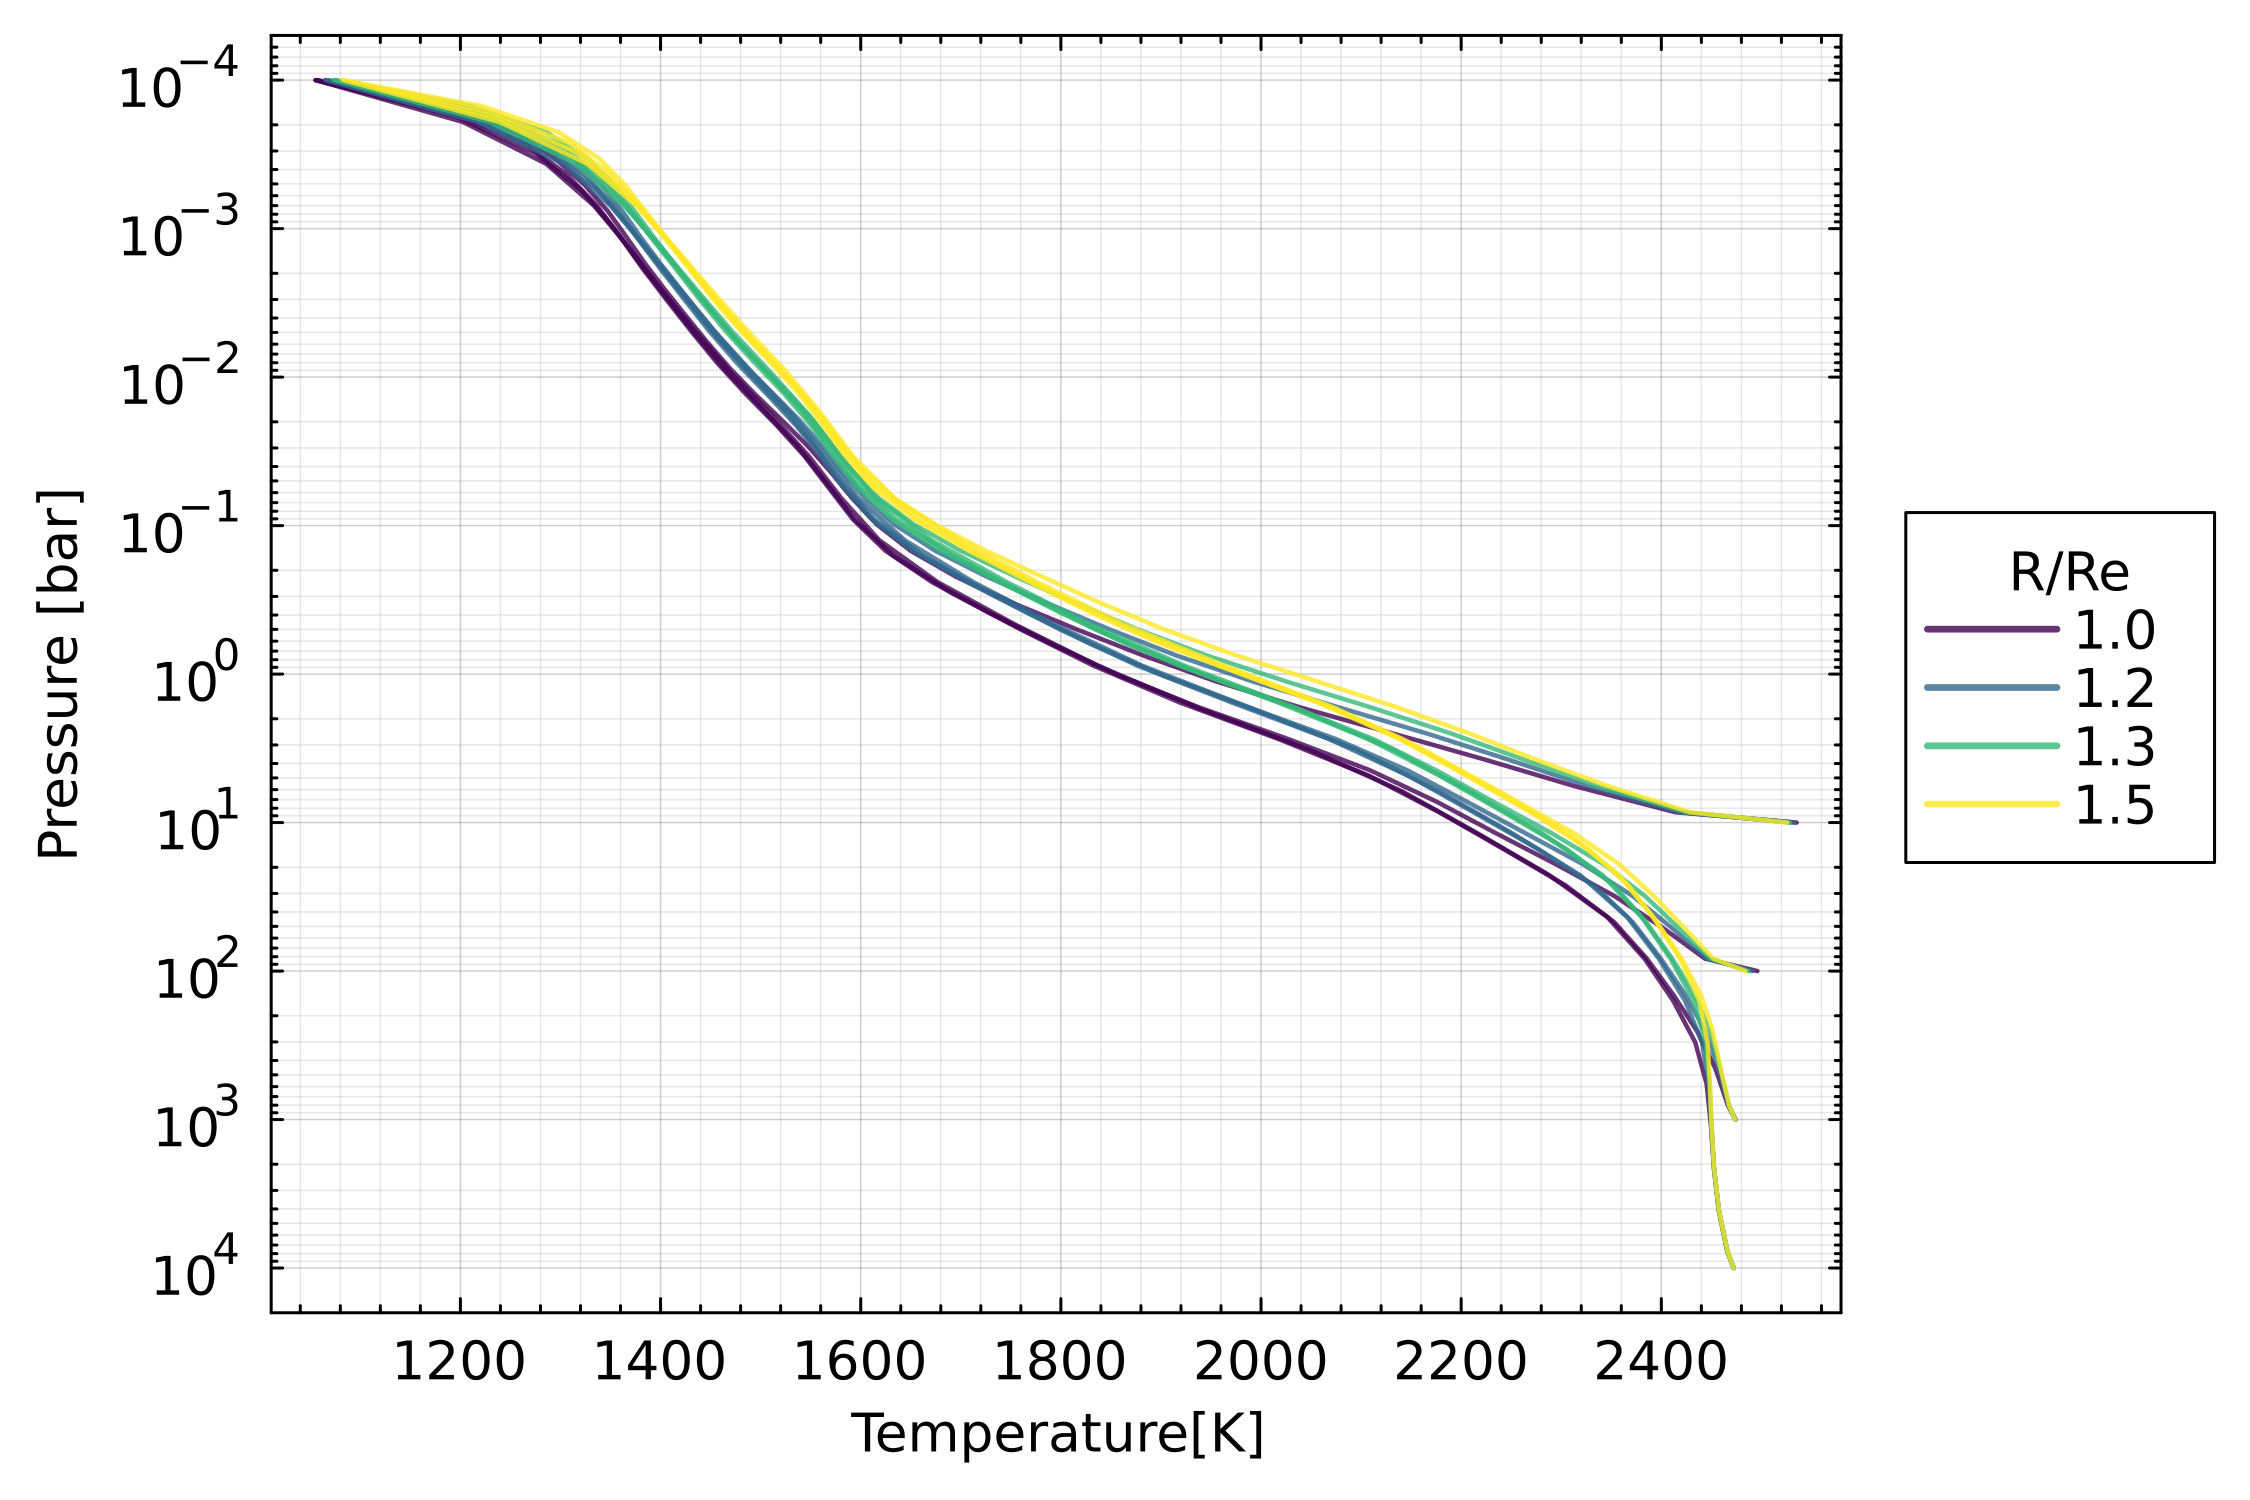

"/home/n/nichollsh/AGNI/out/profiles.pdf"

In [68]:
fs=12
lw=2.5
al=0.8

# find highest psurf
psurf_max::Float64 = 1e3
psurf_idx::Int = 1
for i in 1:ntotal
    this_atm = atm_arr[i]
    if atm_arr[i].pl[end] > psurf_max
        psurf_max = atm_arr[i].pl[end]
        psurf_idx = i
    end
end

# y ticks
arr_P = atm_arr[psurf_idx].pl .* 1.0e-5 # Convert Pa to bar
ylims  = (arr_P[1]/2, arr_P[end]*2)
yticks = 10.0 .^ round.(Int,range( log10(ylims[1]), stop=log10(ylims[2]), step=1))

plt = plot(framestyle=:box, size=(750,500), dpi=300,
                leg=:outerright, legcolumn=-1,
                tickfontsize=fs, guidefontsize=fs, legendfontsize=fs,
                legendtitlefontsize=fs,
                legendtitle="R/Re",
                left_margin=4Plots.mm, bottom_margin=4Plots.mm)


p = Plots.palette(:viridis, nsamps)
lw=1.5

# plot the profiles
for i in 1:nsamps
    for j in 1:nsamps

        k = (i-1)*nsamps + j
        this_atm = atm_arr[k]

        P_surf = inp_ps[i] # bar
        R_surf = inp_rp[j] # R_earth

        col = p[j]
        if i == 1
            lbl = @sprintf("%.1f",R_surf)
        else
            lbl = ""
        end

        plot!(plt, this_atm.tmpl, this_atm.pl* 1.0e-5, linewidth=lw, label=lbl, linealpha=al, color=col)
        # scatter!(plt, this_atm.tmpl[this_atm.mask_c], this_atm.pl[this_atm.mask_c]*1e-5, label="", markercolor=:black)
    end
end

# decorate
xlabel!(plt, "Temperature[K]")
xaxis!(plt, minorgrid=true)
ylabel!(plt, "Pressure [bar]")
yflip!(plt)
yaxis!(plt, yscale=:log10, ylims=ylims, yticks=yticks)
display(plt)
savefig(plt,joinpath(output_dir,"profiles.pdf"))

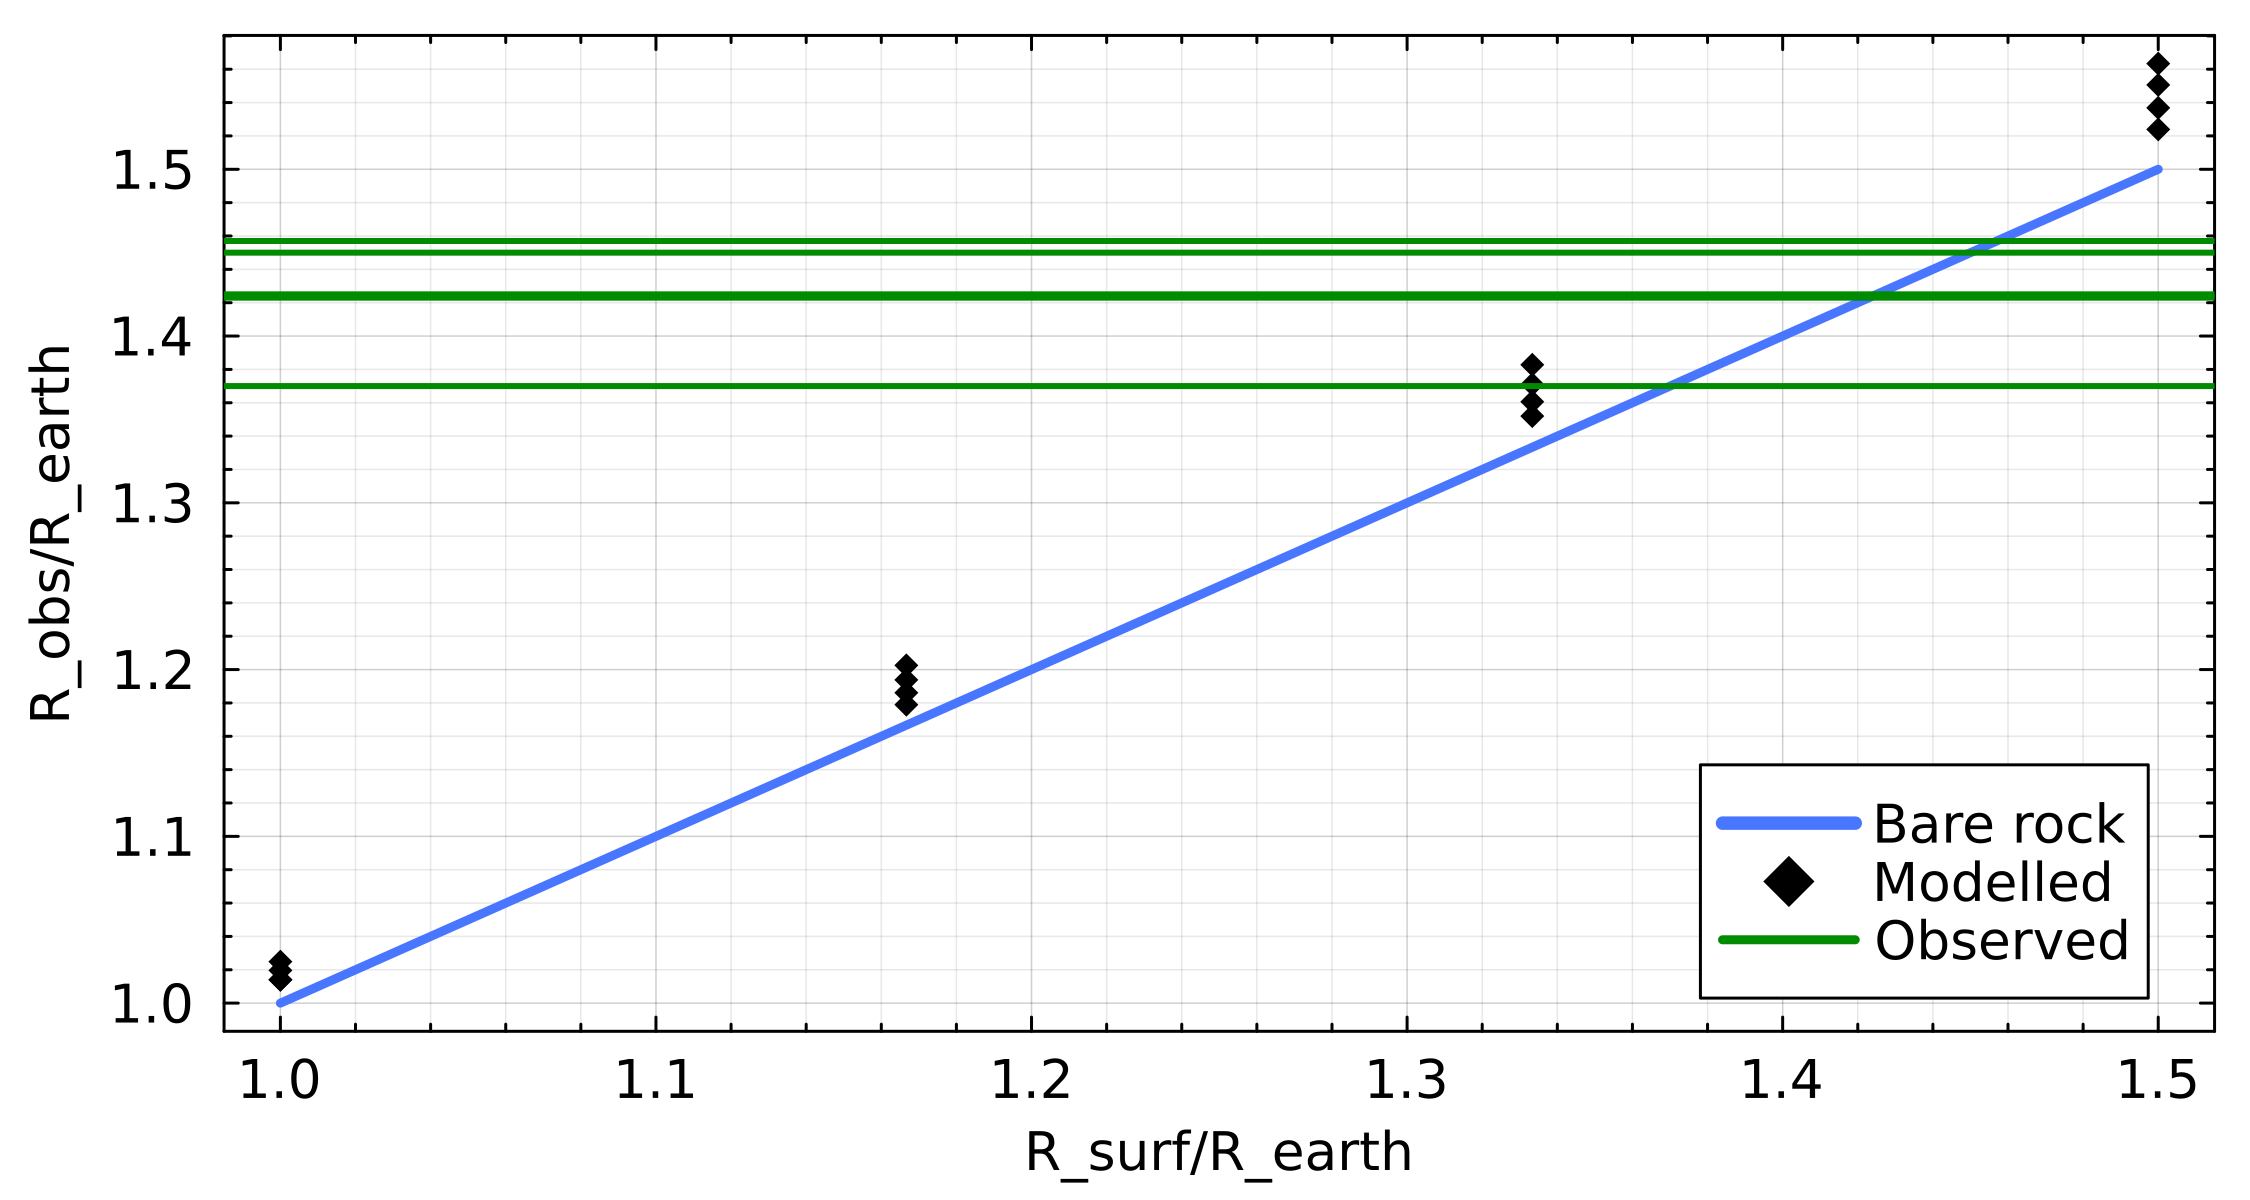

"/home/n/nichollsh/AGNI/out/radius_rsurf.pdf"

In [16]:
fs=12

# radius-radius plot
plt = plot(framestyle=:box, size=(750,400), dpi=300,
                tickfontsize=fs, guidefontsize=fs, legendfontsize=fs,
                left_margin=4Plots.mm, bottom_margin=4Plots.mm)

# plot the bare rock case
plot!(plt, inp_rp, inp_rp, label="Bare rock", lw=3, color="royalblue1")

# plot the points
scatter_y = zeros(Float64, ntotal)
for i in 1:ntotal
    scatter_y[i] = atm_arr[i].transspec_r/R_earth
end
scatter!(plt, inp_rp_arr, scatter_y, label="Modelled", color="black", ms=4, markershape=:diamond)

# plot the observation
obs = Float64[1.425, 1.457, 1.37, 1.45, 1.423]
hline!(plt, obs, label="Observed", color="green4", lw=2)

# decorate
xlabel!(plt, "R_surf/R_earth")
xaxis!(minorgrid=true)
ylabel!(plt, "R_obs/R_earth")
display(plt)
savefig(plt,joinpath(output_dir,"radius_rsurf.pdf"))

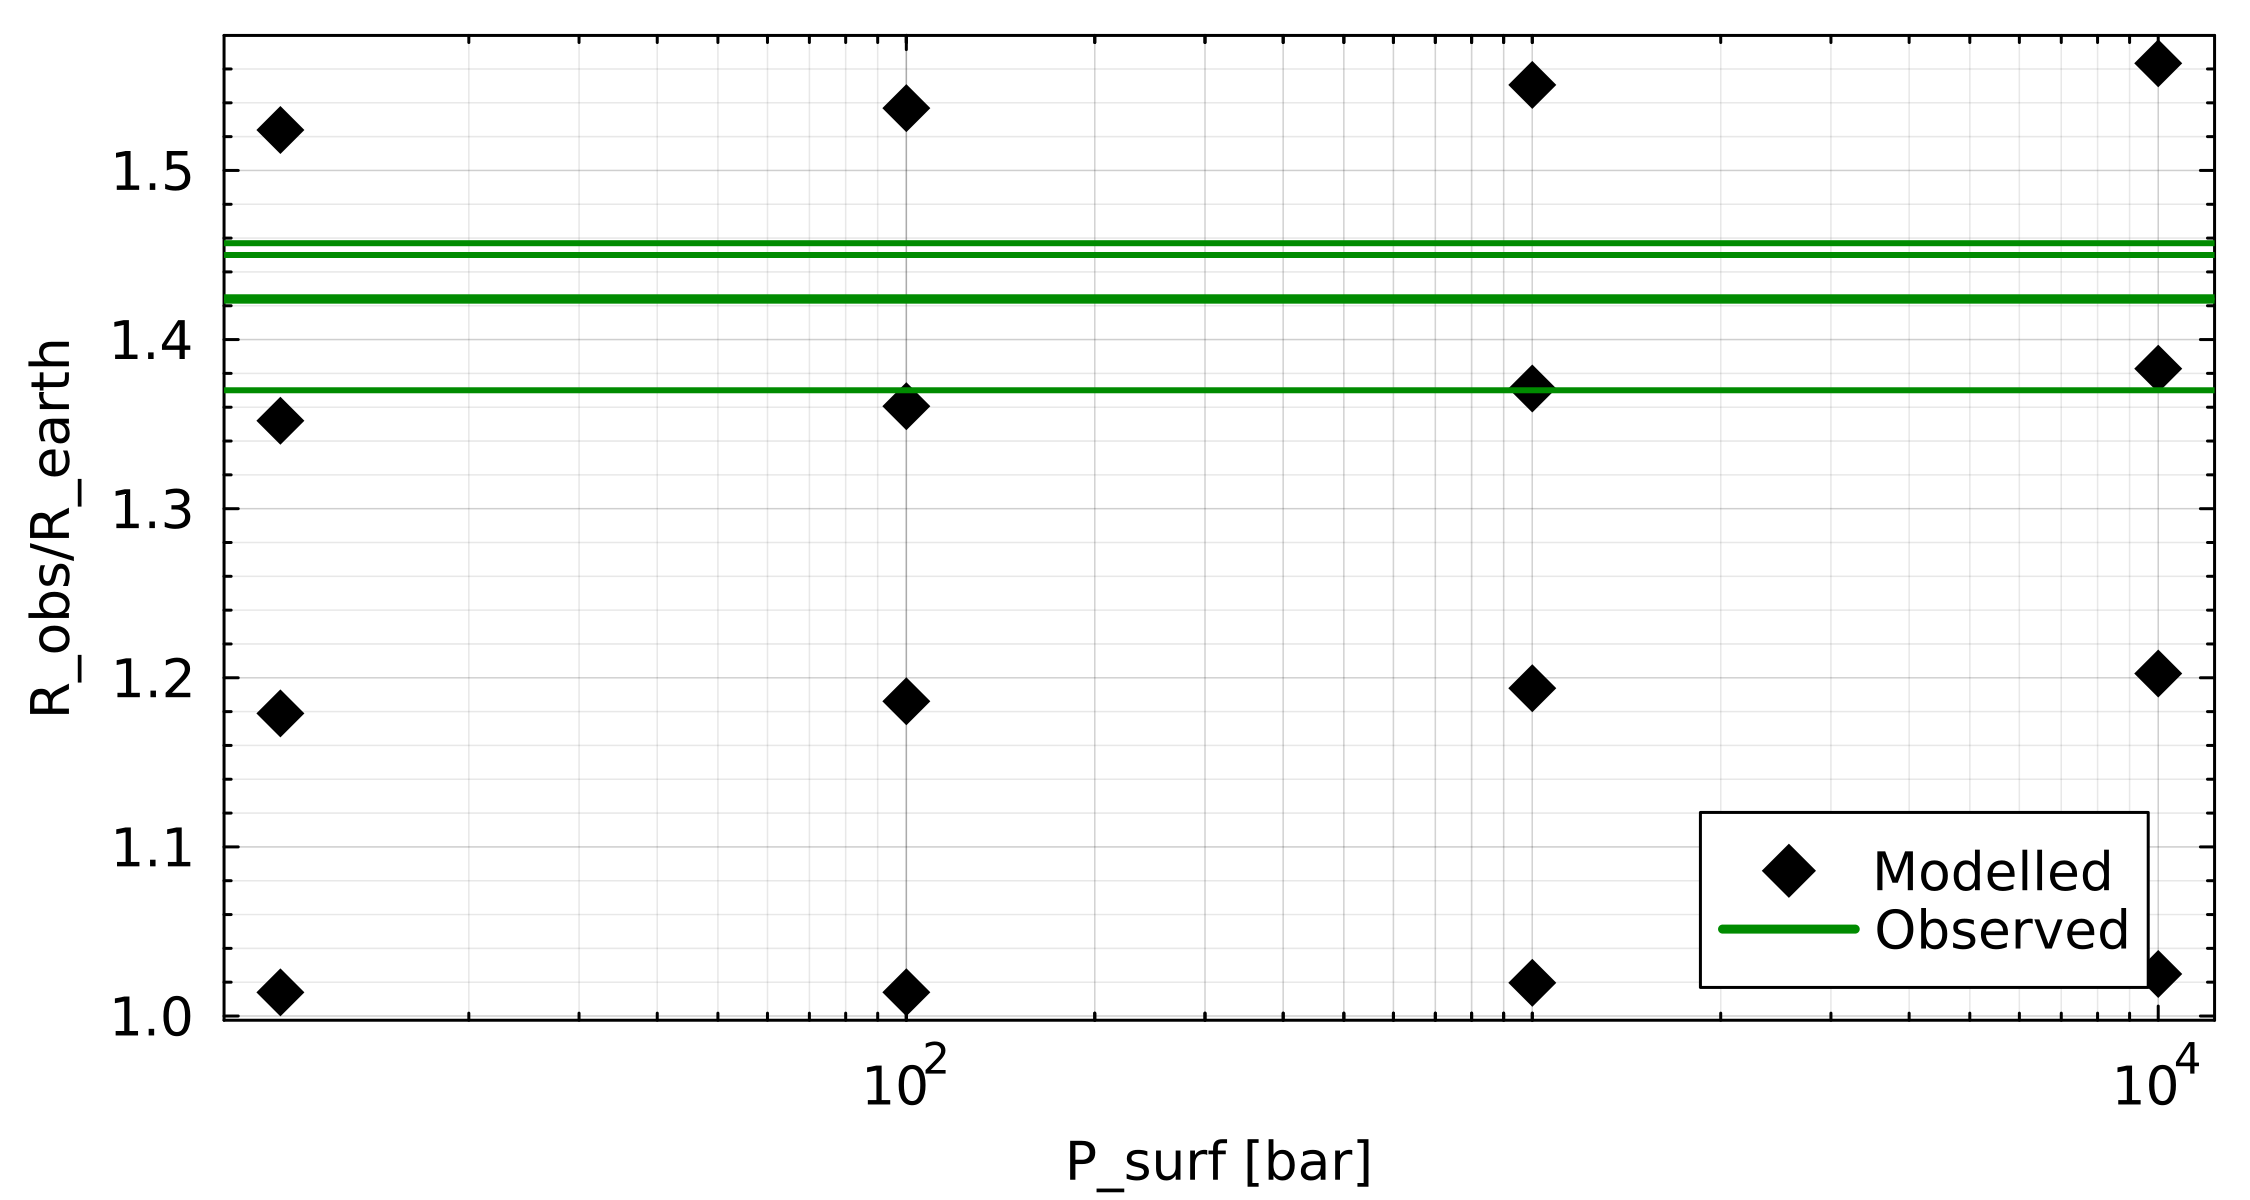

"/home/n/nichollsh/AGNI/out/radius_psurf.pdf"

In [17]:
fs=12

# radius-pressure plot
plt = plot(framestyle=:box, size=(750,400), dpi=300,
                tickfontsize=fs, guidefontsize=fs, legendfontsize=fs,
                left_margin=4Plots.mm, bottom_margin=4Plots.mm)

# plot the bare rock case
# plot!(plt, inp_rp_arr, inp_rp_arr, label="Bare rock", lw=3, color="royalblue1")

# plot the points
scatter_y = zeros(Float64, ntotal)
for i in 1:ntotal
    scatter_y[i] = atm_arr[i].transspec_r/R_earth
end
scatter!(plt, inp_ps_arr, scatter_y, label="Modelled", color="black", ms=8, markershape=:diamond)

# plot the observation
obs = Float64[1.425, 1.457, 1.37, 1.45, 1.423]
hline!(plt, obs, label="Observed", color="green4", lw=2)

# decorate
xlabel!(plt, "P_surf [bar]")
xaxis!(minorgrid=true, xscale=:log10)
ylabel!(plt, "R_obs/R_earth")
display(plt)
savefig(plt,joinpath(output_dir,"radius_psurf.pdf"))

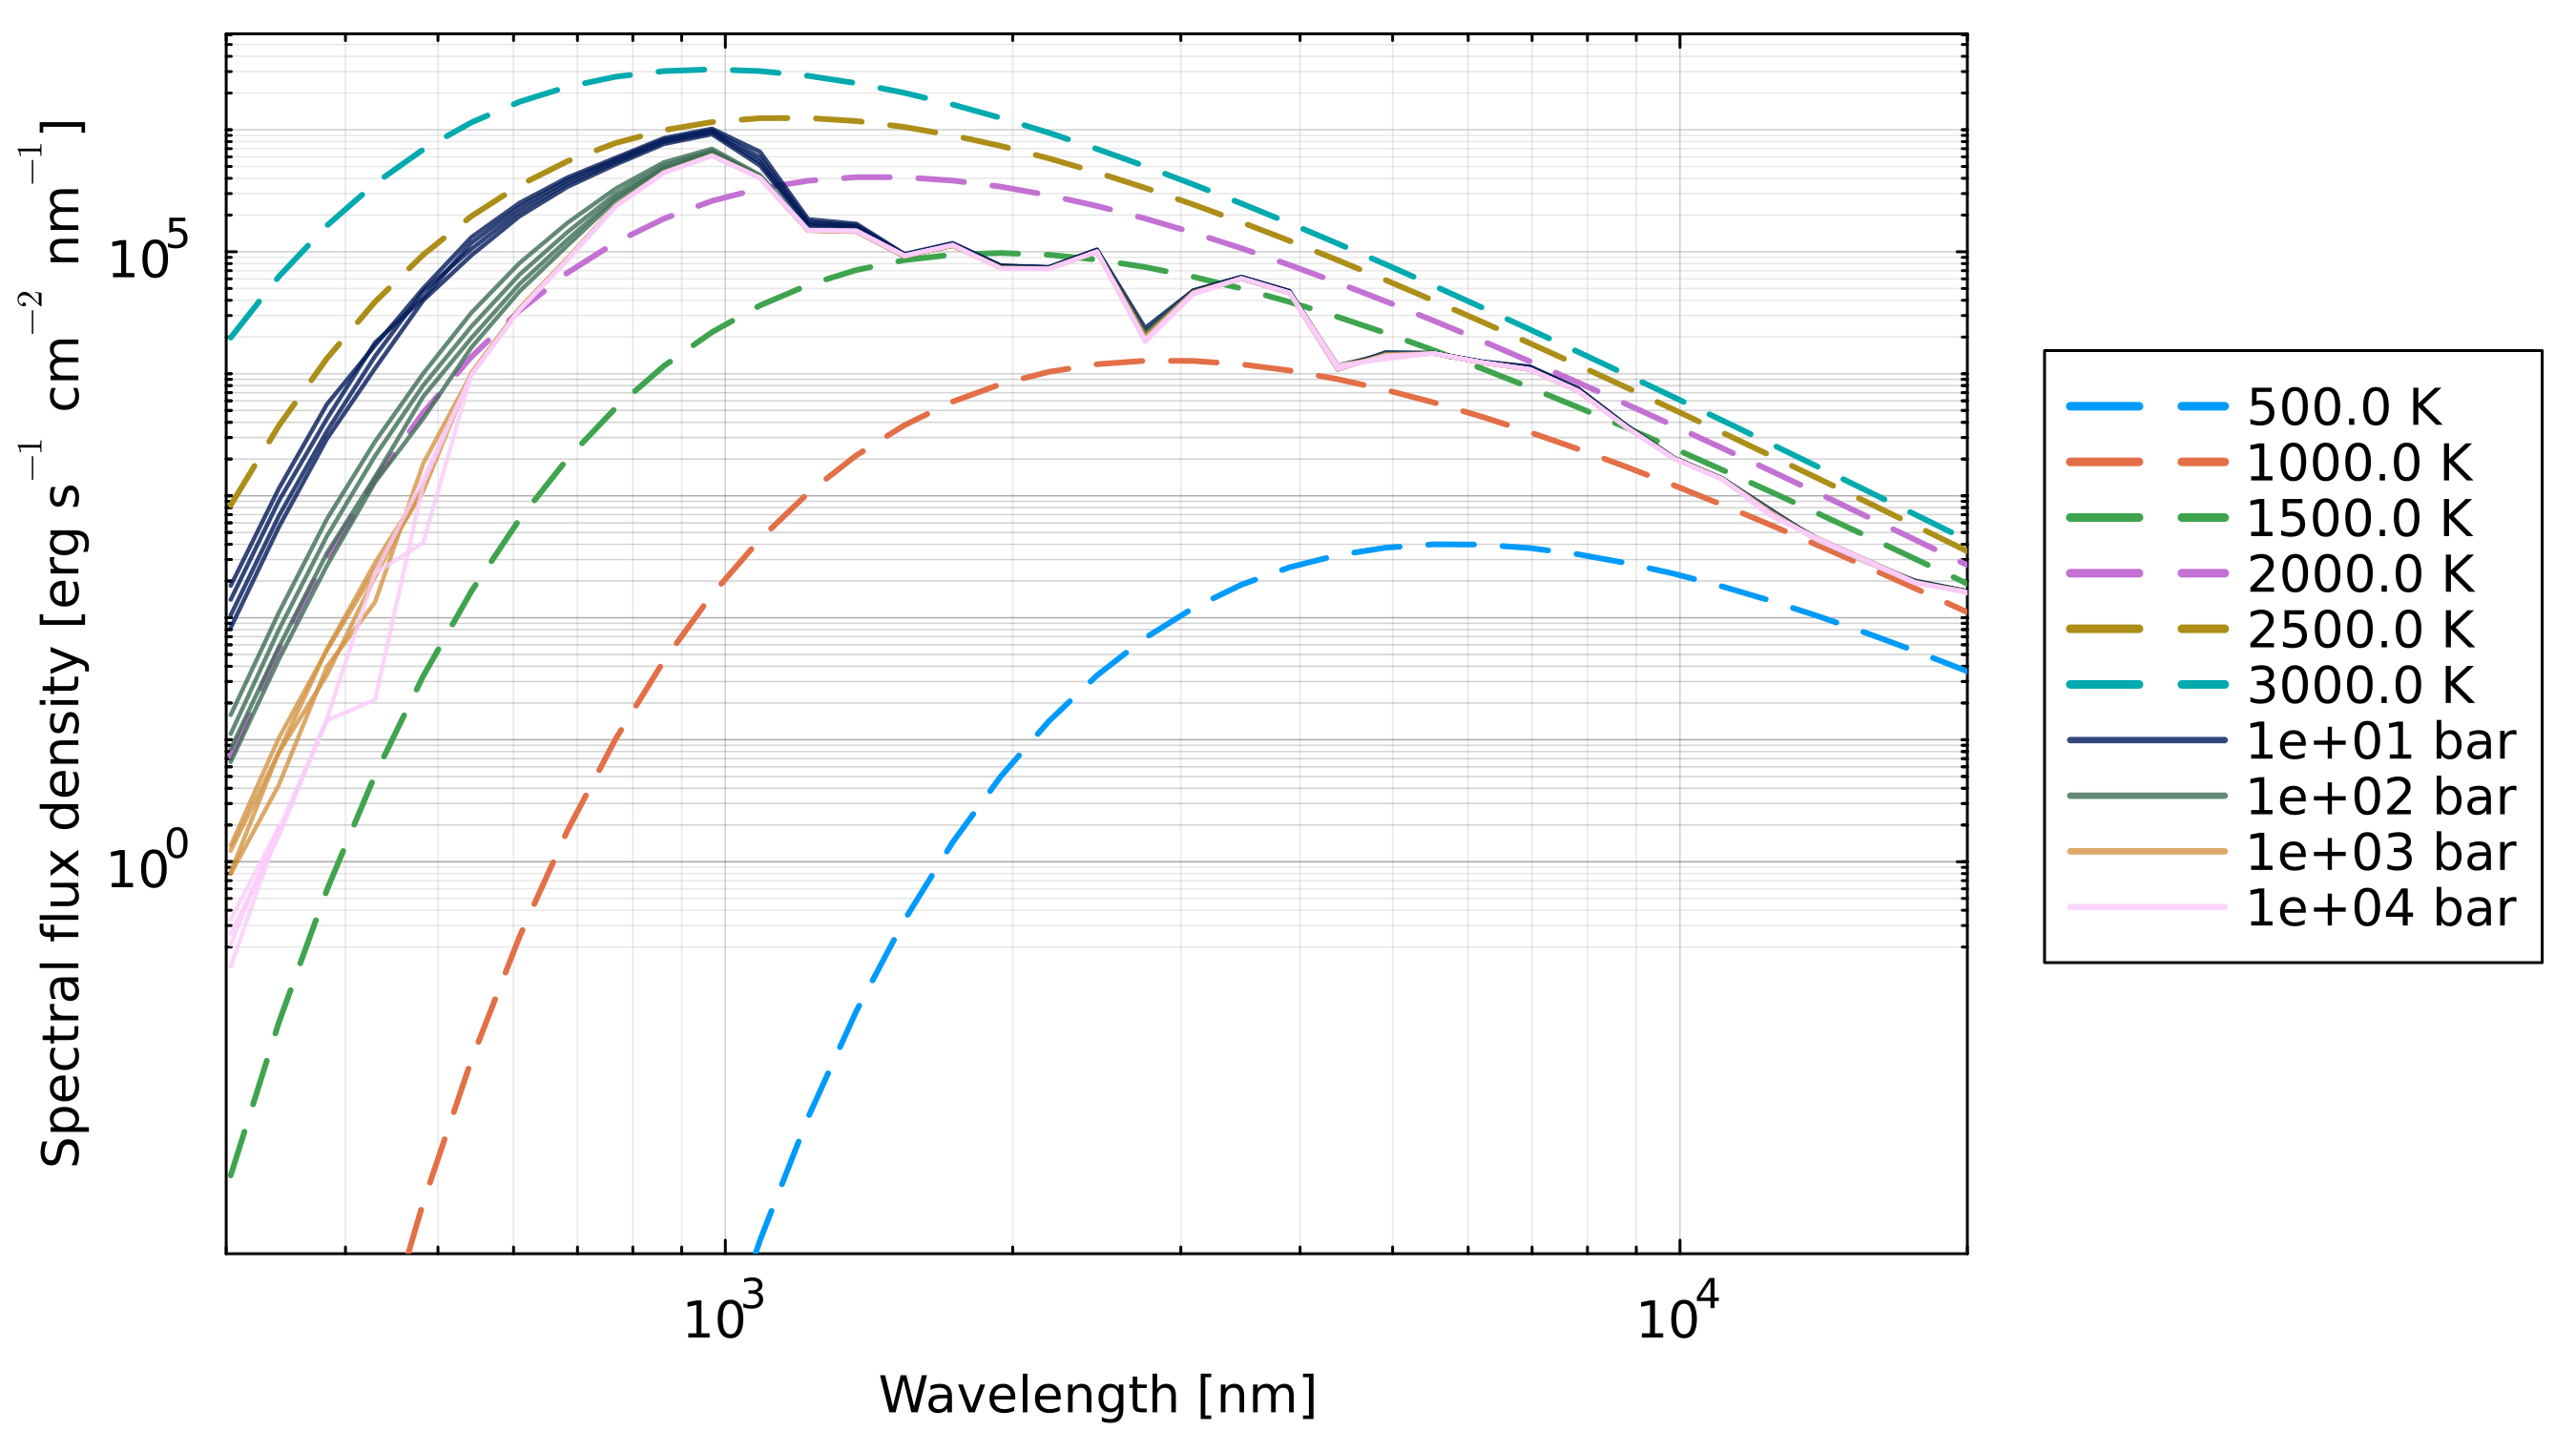

"/home/n/nichollsh/AGNI/out/emission.pdf"

In [160]:
fs=12

# emission spectra
plt = plot(framestyle=:box, size=(900,500), dpi=300,
                leg=:outerright, legcolumn=-1,
                tickfontsize=fs, guidefontsize=fs, legendfontsize=fs,
                legendtitlefontsize=fs,
                # legendtitle="P_surf [bar]",
                left_margin=4Plots.mm, bottom_margin=4Plots.mm)

x = zeros(Float64, atmos.nbands)
x[:] .= atmos.bands_cen[:] .* 1e9 # wavelength, nm
y = zeros(Float64, atmos.nbands)

p = Plots.palette(:batlow, nsamps)
lw=1.5

# plot planck functions
for t in range(start=500.0, stop=3000.0, step=500.0)
    plot!(plt, x, phys.evaluate_planck.(x[:], t).*1e3, ls=:dash, label="$t K", lw=2)
end

# plot the spectra
for i in 1:nsamps
    for j in 1:nsamps

        k = (i-1)*nsamps + j
        this_atm = atm_arr[k]

        P_surf = inp_ps[i] # bar
        R_surf = inp_rp[j] # R_earth

        col = p[i]
        if j == 1
            lbl = @sprintf("%.e bar",P_surf)
        else
            lbl = ""
        end

        y[:] .= this_atm.band_u_lw[1,:] ./ (this_atm.bands_wid[:] .* 1e9) * 1e3
        plot!(plt, x, y, linewidth=lw, label=lbl, linealpha=al, color=col)
    end
end


# decorate
xaxis!(plt, xlabel="Wavelength [nm]", minorgrid=true, xlims=(300.0, 20e3), xscale=:log10)
yaxis!(plt, ylabel=L"Spectral flux density [erg s$^{-1}$ cm$^{-2}$ nm$^{-1}$]", yscale=:log10, ylims=(maximum(y)/1e9, maximum(y)*10))
display(plt)
savefig(plt,joinpath(output_dir,"emission.pdf"))

In [19]:
for (i, atm) in enumerate(atm_arr)
    println("Writing index $i")
    dump.write_ncdf(atm, joinpath(atm.OUT_DIR, "$i.nc"))
end
println("Done writing files")

Writing index 1
Writing index 2
Writing index 3
Writing index 4
Writing index 5
Writing index 6
Writing index 7
Writing index 8
Writing index 9
Writing index 10
Writing index 11
Writing index 12
Writing index 13
Writing index 14
Writing index 15
Writing index 16
Done writing files
